   # Forecasting Rotten Tomatoes Movie's Audience Ratings 

## 1. Overview of the Data

### 1.1 Importing necessary libraries 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None) 
import warnings
warnings.filterwarnings('ignore')

### 1.2 Loading the data

In [2]:
data = pd.read_excel('Rotten_Tomatoes_Movies3.xls')
data.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


### 1.3 Summary of the Data

- **movie_title**: Movie title as a string, unique for each entry.  
- **movie_info**: Brief synopsis or plot description.  
- **critics_consensus**: Aggregated critics' opinion, may have missing values.  
- **rating**: Age-appropriateness rating (e.g., PG, R), categorical.  
- **genre**: Movie genres as a comma-separated string.  
- **directors**: Name(s) of the movie's director(s).  
- **writers**: Name(s) of the movie's writer(s).  
- **cast**: List of main cast members, comma-separated.  
- **in_theaters_date**: Release date of the movie in theaters.  
- **on_streaming_date**: Date when the movie became available on streaming platforms.  
- **runtime_in_minutes**: Duration of the movie in minutes.  
- **studio_name**: Name of the production or distribution studio.  
- **tomatometer_status**: Tomatometer certification status (e.g., Rotten, Fresh).  
- **tomatometer_rating**: Percentage rating on the Tomatometer scale.  
- **tomatometer_count**: Number of critics' reviews counted.  
- **audience_rating**: Audience rating percentage ***(Target)***

## 2. Exploratory Data Analysis (EDA)

### 2.1 Distribution Analysis

Content Rating category: ['PG' 'R' 'NR' 'G' 'PG-13' 'PG-13)' 'NC17' 'R)']


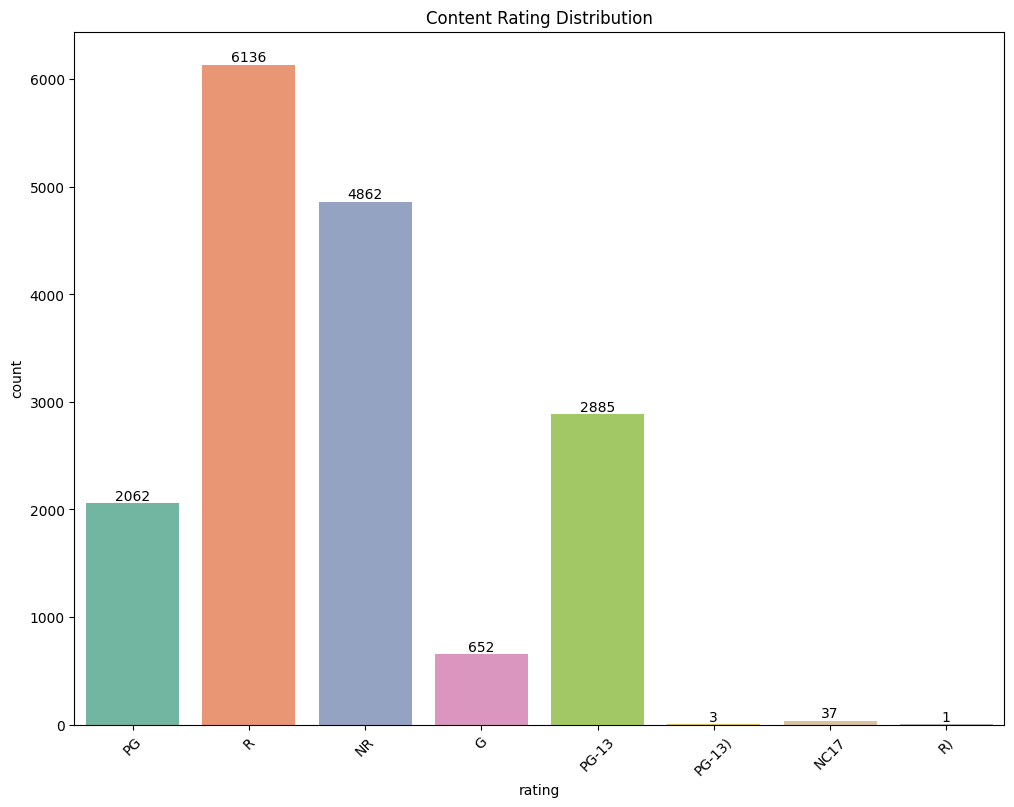

Tomatometer status category: ['Rotten' 'Certified Fresh' 'Fresh']


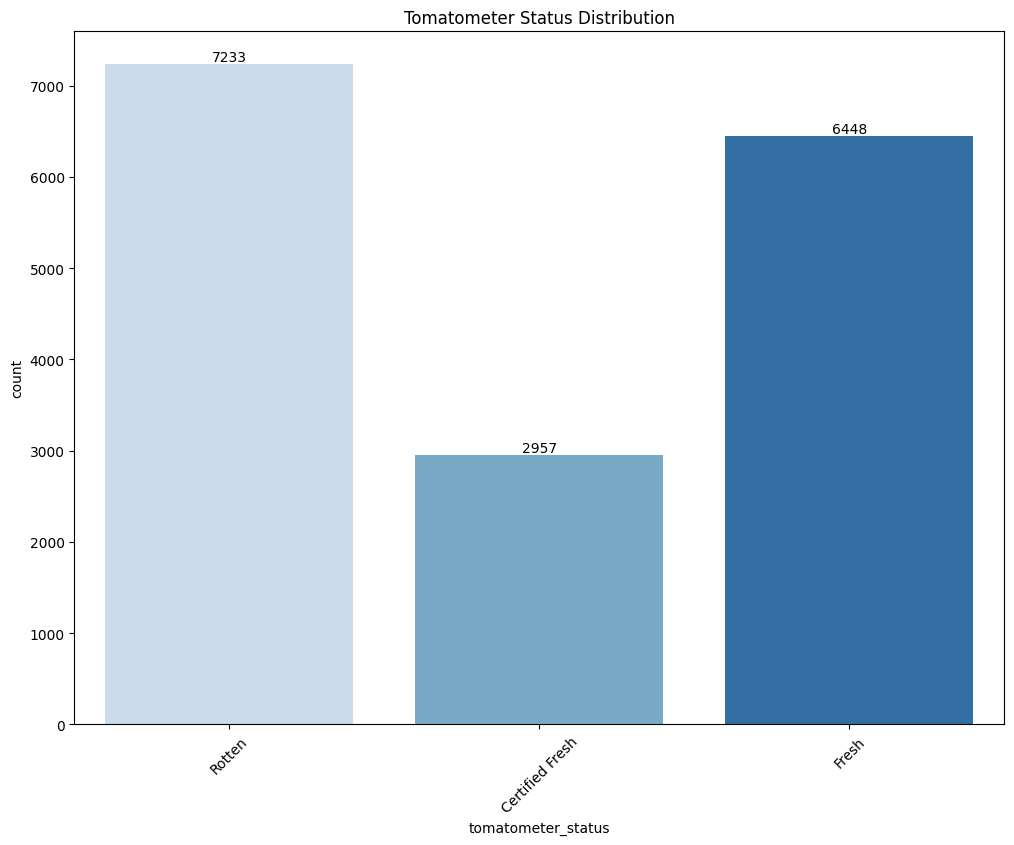

In [3]:
print(f'Content Rating category: {data.rating.unique()}')

plt.figure(figsize=(12, 9))
ax = sns.countplot(x='rating', data=data, palette='Set2')
ax.set_title('Content Rating Distribution')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()

print(f'Tomatometer status category: {data.tomatometer_status.unique()}')

plt.figure(figsize=(12, 9))
ax = sns.countplot(x='tomatometer_status', data=data, palette='Blues')
ax.set_title('Tomatometer Status Distribution')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()


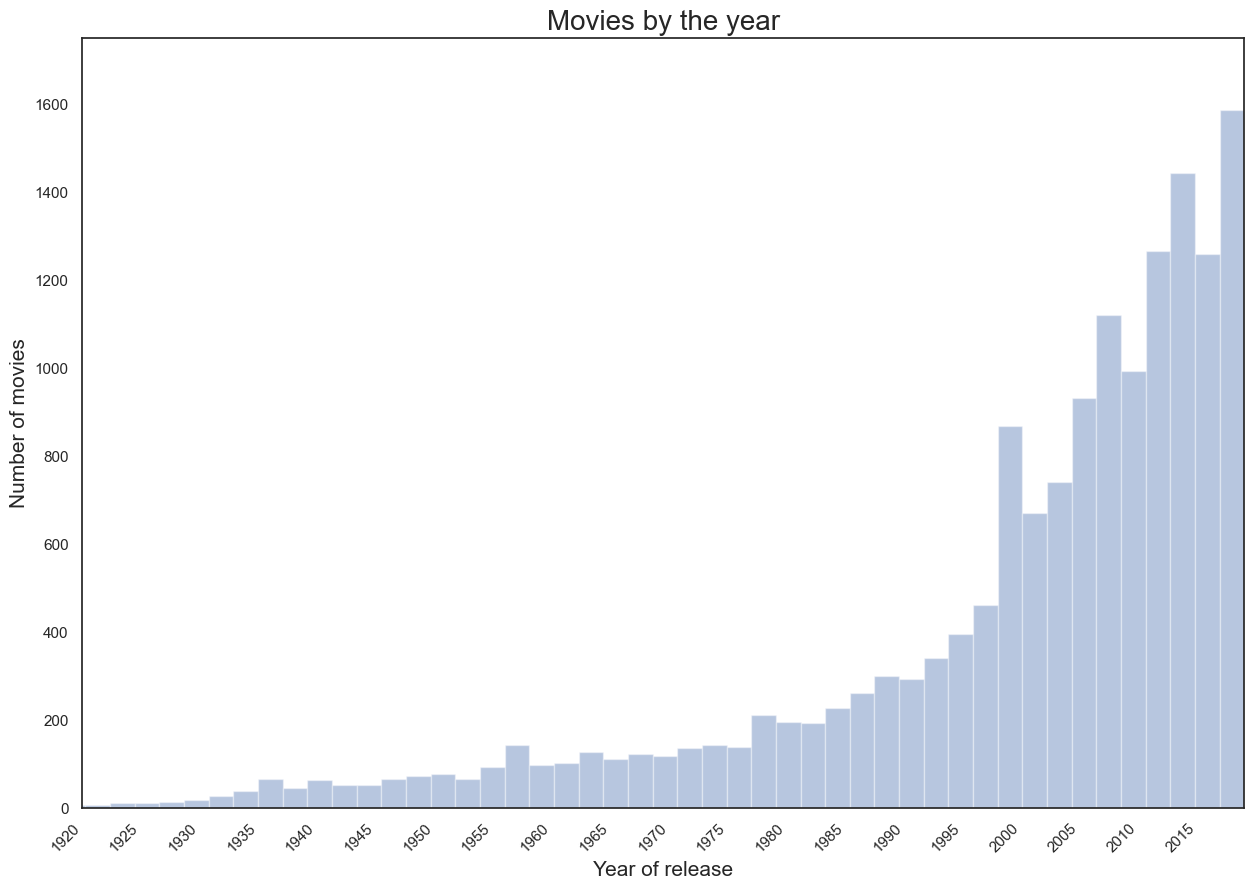

In [4]:
import numpy as np

data = data[data.in_theaters_date.notnull()]
data['in_theaters_date'] = pd.to_datetime(data['in_theaters_date'])
data['movie_year'] =data['in_theaters_date'].apply(lambda x: x.year)

sns.set(style="white")

plt.figure(figsize=(15,10))
plt.title('Movies by the year', size=20)
sns.distplot(data.movie_year, kde=False)
plt.ylabel('Number of movies', size=15)
plt.xlabel('Year of release',size=15)
plt.axis([1920, 2019, 0, 1750])
plt.xticks(np.arange(1920, 2018, step=5),rotation=45, ha='right')
plt.show()

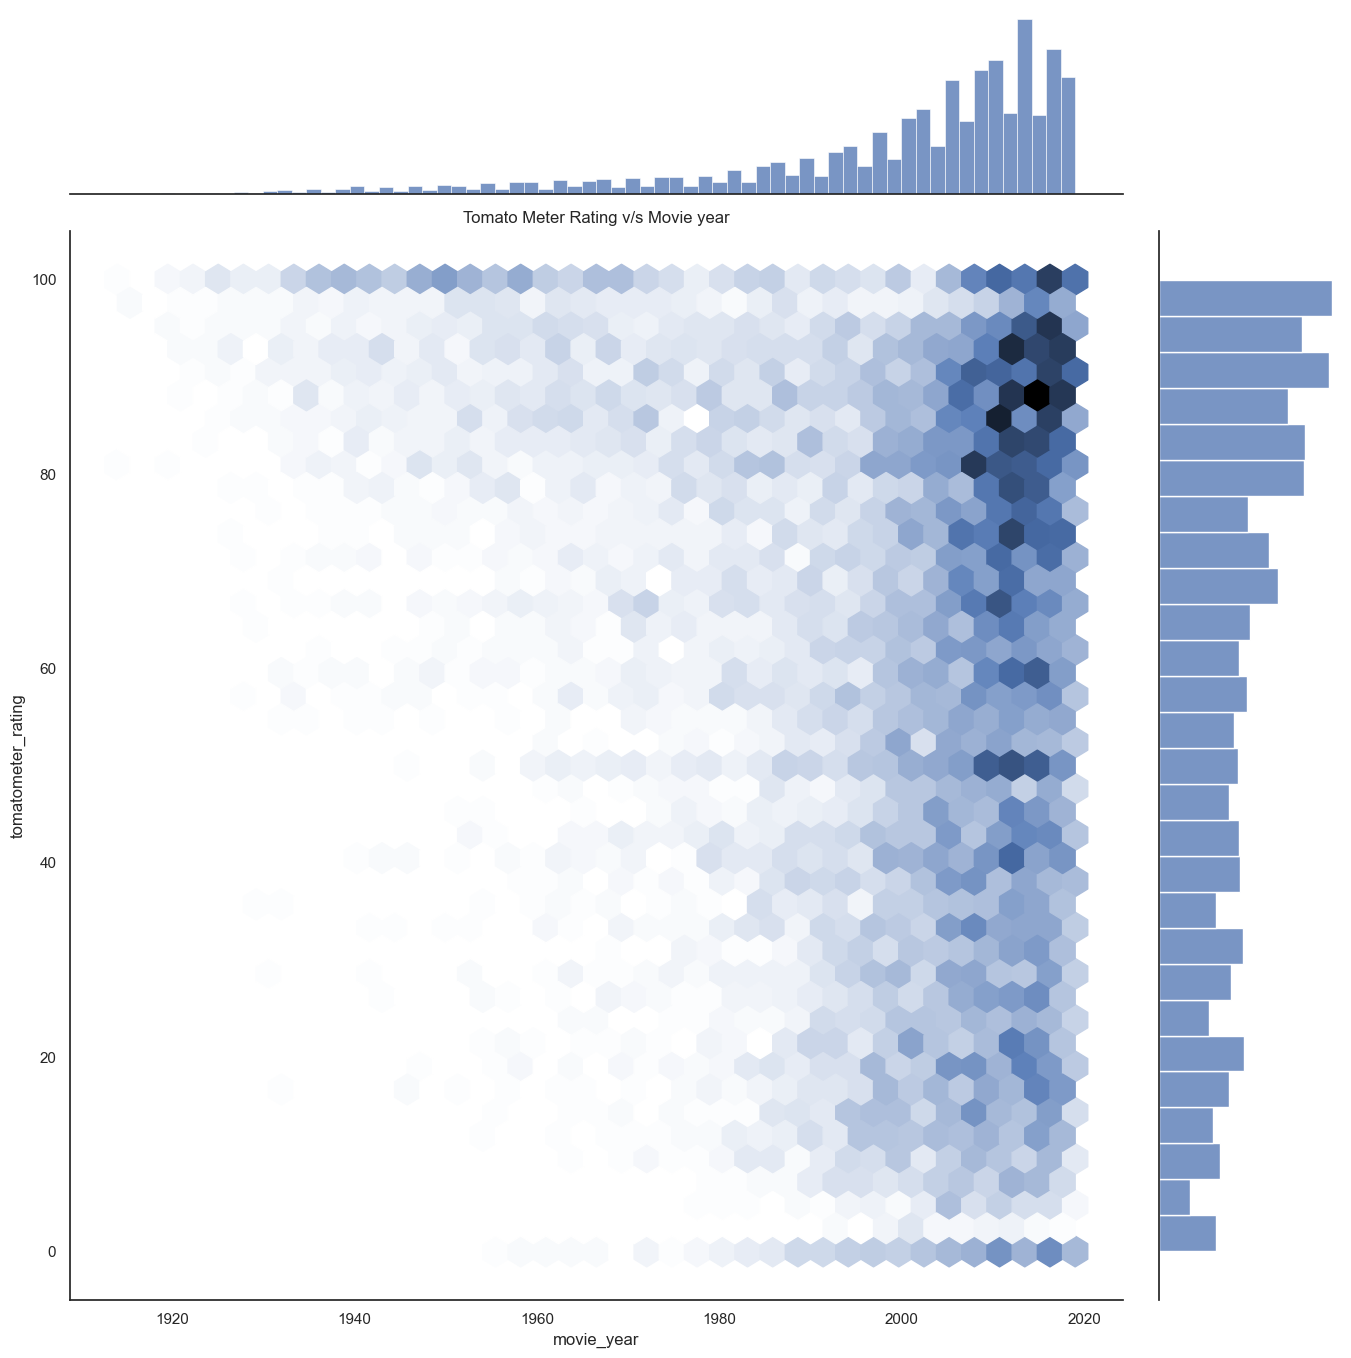

In [5]:
data =data[(data.tomatometer_rating.notnull()) &
                      (data.audience_rating.notnull())]
sns.jointplot(x=data['movie_year'], y=data['tomatometer_rating'],
              kind="hex").fig.set_size_inches(15,15)
plt.title("Tomato Meter Rating v/s Movie year")
plt.show()

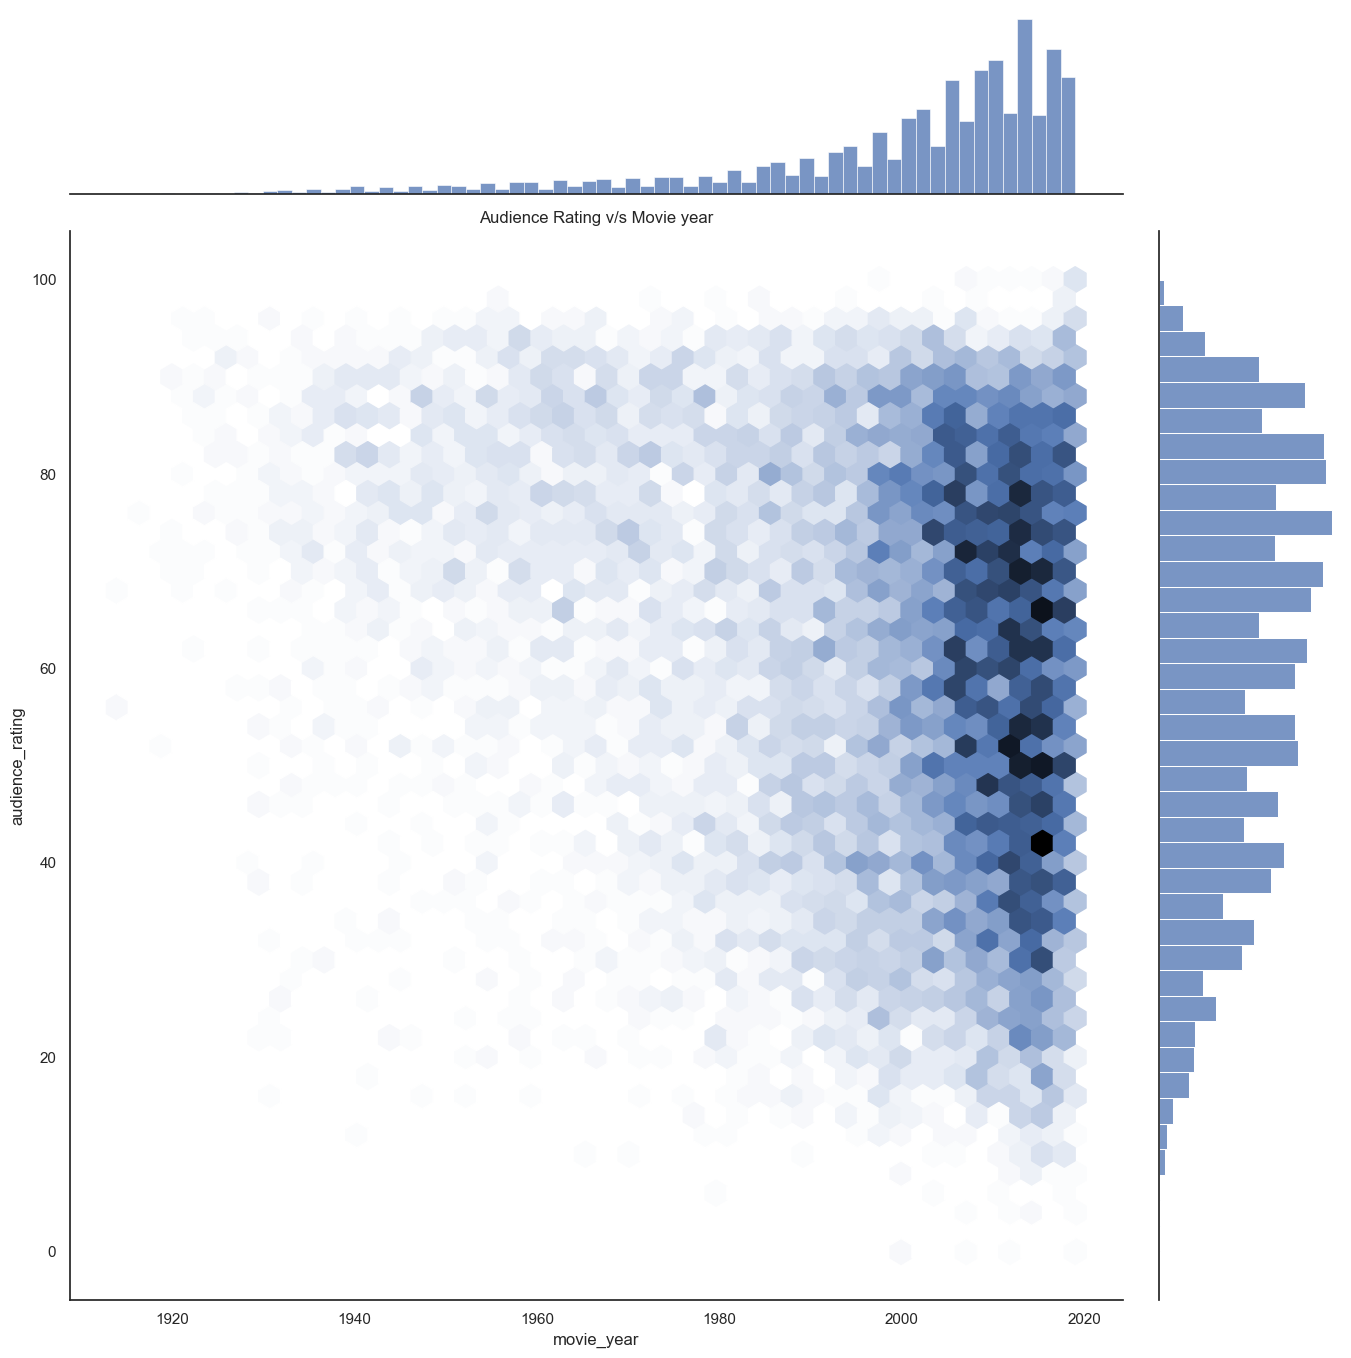

In [6]:
sns.jointplot(x=data['movie_year'], y=data['audience_rating'],
              kind="hex").fig.set_size_inches(15,15)


plt.title("Audience Rating v/s Movie year")
plt.show()

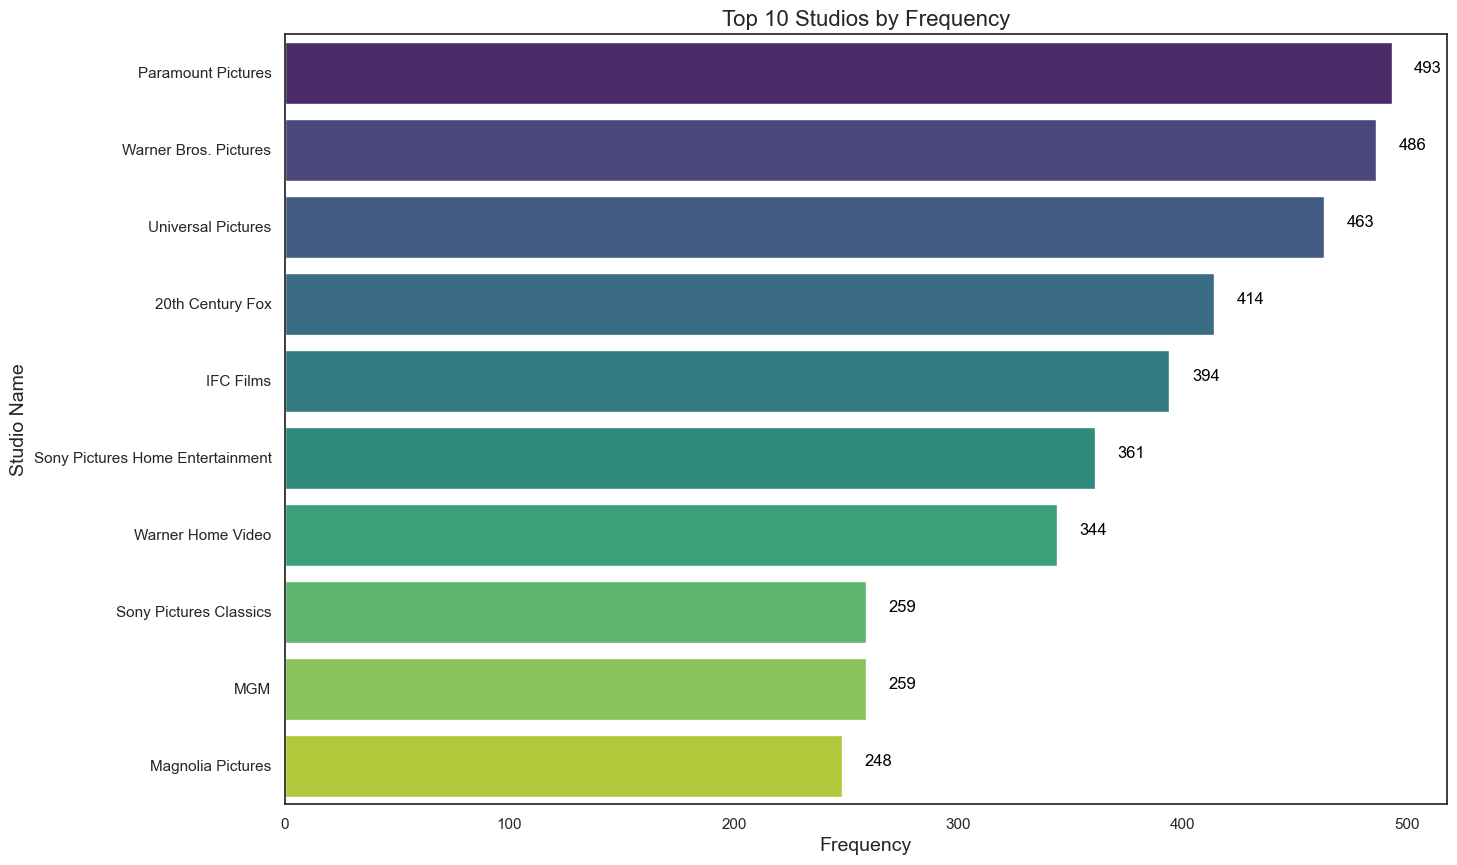

In [7]:
plt.figure(figsize=(15, 10))
count = data['studio_name'].value_counts()[:10]

# Correct the barplot arguments and ensure palette values are valid
sns.barplot(x=count.values, y=count.index, palette="viridis")

# Annotate the bars with their respective values
for i, v in enumerate(count.values):
    plt.text(v + 10, i, str(v), color='black', fontsize=12)

plt.title("Top 10 Studios by Frequency", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Studio Name", fontsize=14)
plt.show()


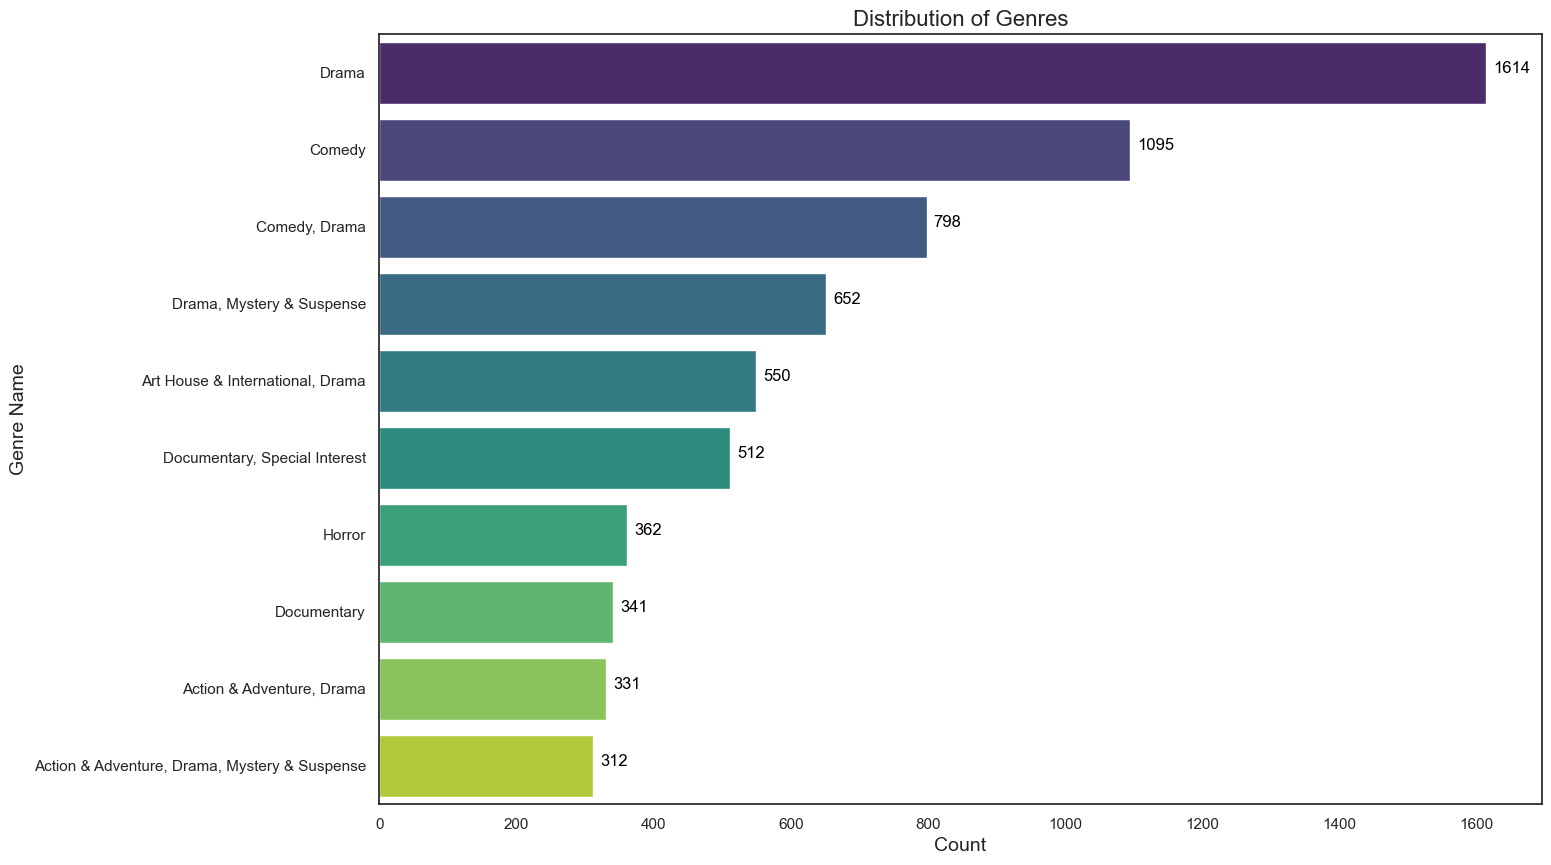

In [8]:
data['first_genre'] = data['genre'].str.split(',').str[0]


plt.figure(figsize=(15, 10))
count = data['genre'].value_counts()[:10]

# Correct the barplot arguments and ensure palette values are valid
sns.barplot(x=count.values, y=count.index, palette="viridis")

# Annotate the bars with their respective values
for i, v in enumerate(count.values):
    plt.text(v + 10, i, str(v), color='black', fontsize=12)

plt.title("Distribution of Genres", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Genre Name", fontsize=14)
plt.show()

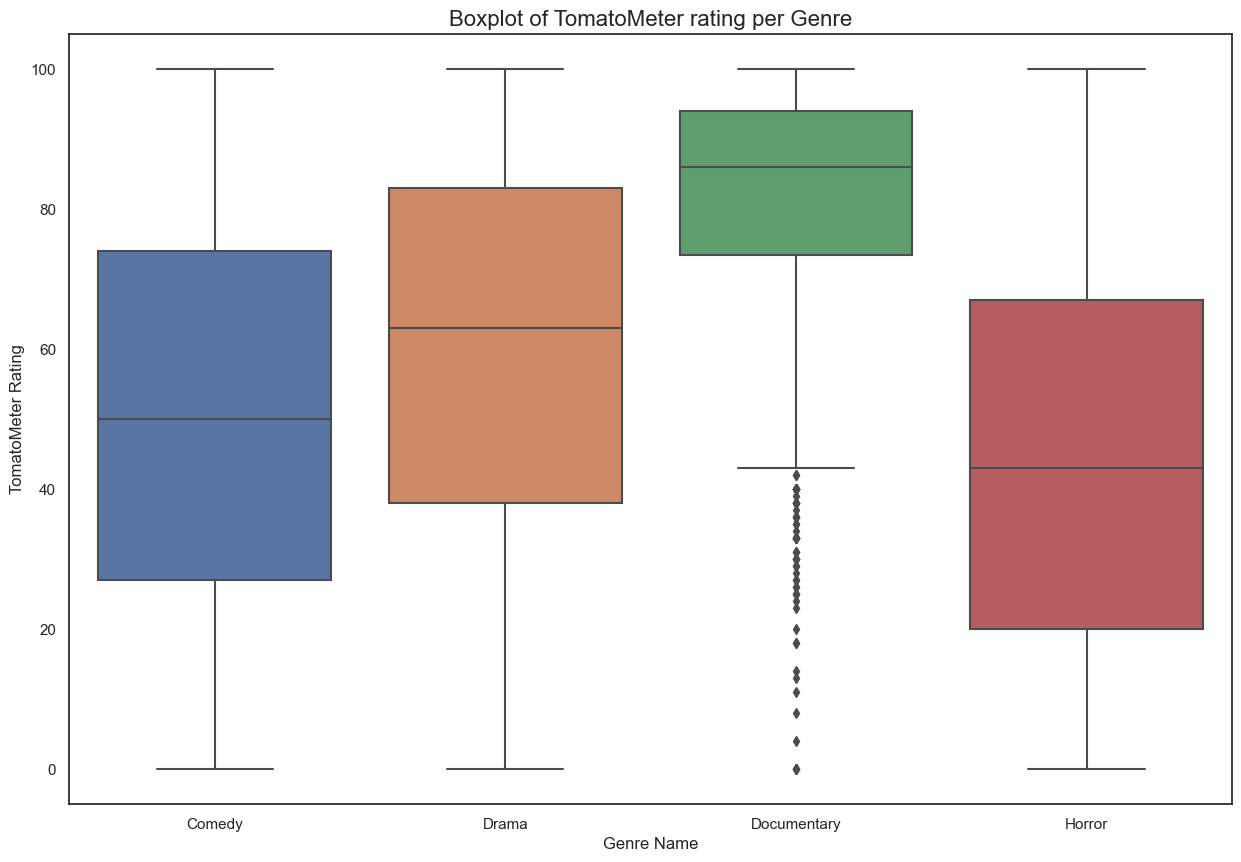

In [9]:
top_genres = list(count.index)
movie_genres_df = data[data['first_genre'].isin(top_genres)]
movie_genres_df = movie_genres_df[pd.notnull(movie_genres_df[['first_genre', 'tomatometer_rating', 'tomatometer_status', 'tomatometer_count',
                                                              'audience_rating']])]

plt.figure(figsize=(15, 10))
sns.boxplot(x='first_genre', y='tomatometer_rating', data=movie_genres_df)
plt.xlabel("Genre Name",fontsize=12)
plt.ylabel("TomatoMeter Rating",fontsize=12)
plt.title("Boxplot of TomatoMeter rating per Genre", fontsize=16)
plt.show()

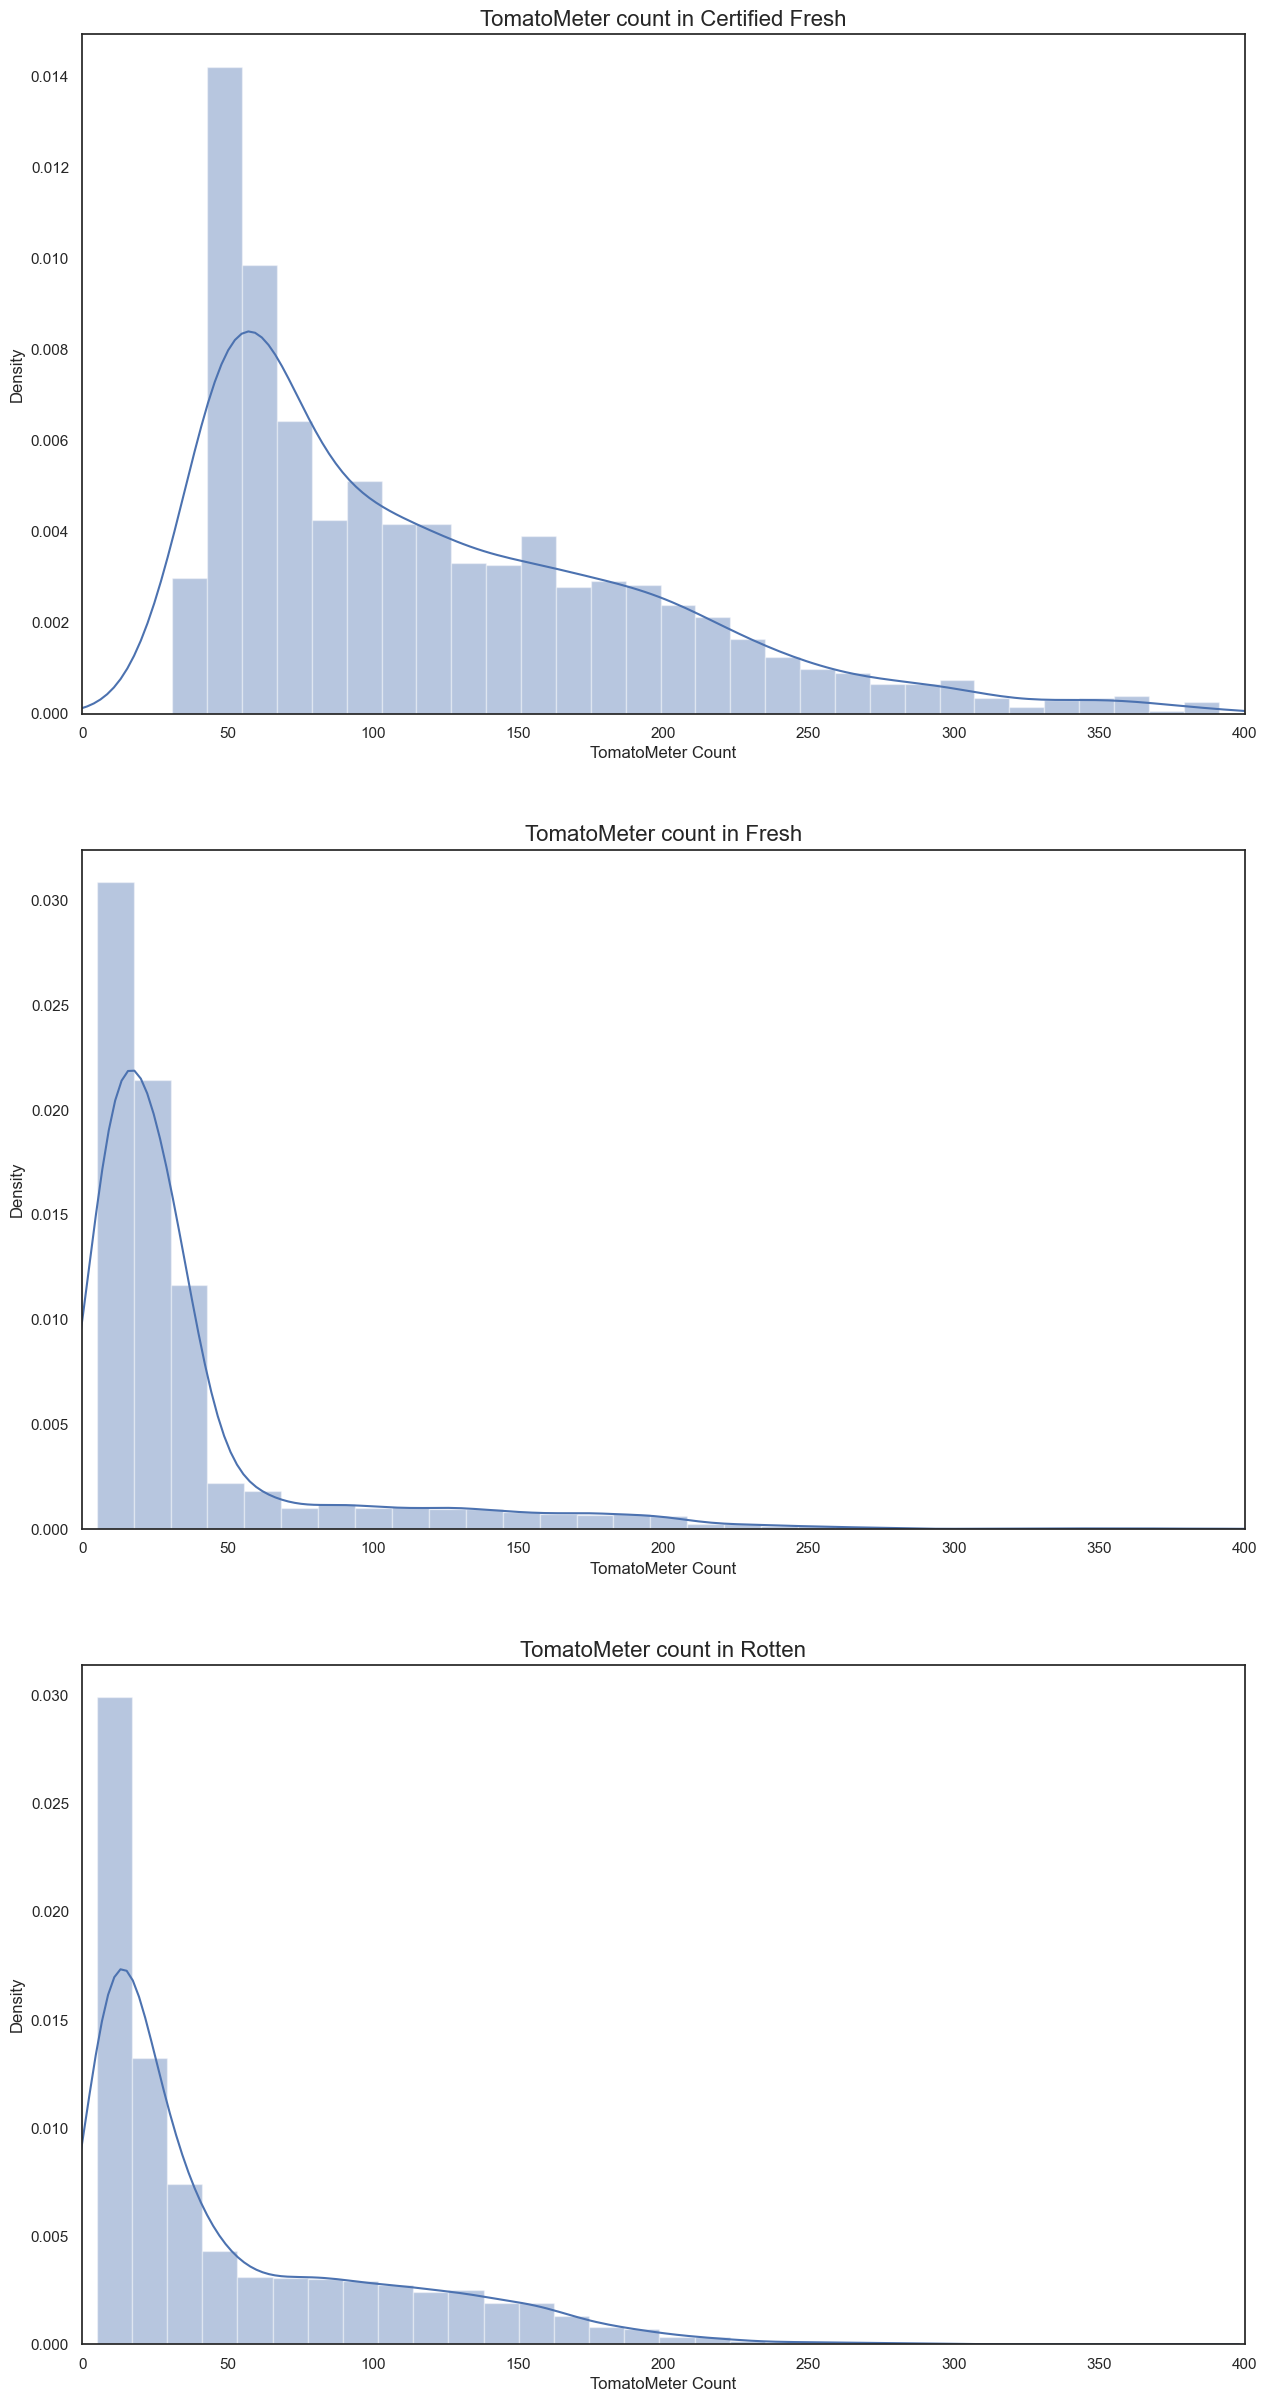

In [10]:
f,ax = plt.subplots(3,1, figsize=(15, 30))
sns.distplot(movie_genres_df[(movie_genres_df['tomatometer_status'] == 'Certified Fresh') &
                             (movie_genres_df['tomatometer_count'] <= 400)].tomatometer_count, ax=ax[0], bins=30)
ax[0].set_title('TomatoMeter count in Certified Fresh', fontsize=16)
ax[0].set_xlabel("TomatoMeter Count",fontsize=12)
ax[0].set_xlim([0,400])
sns.distplot(movie_genres_df[(movie_genres_df['tomatometer_status'] == 'Fresh') &
                             (movie_genres_df['tomatometer_count'] <= 400)].tomatometer_count, ax=ax[1], bins=30)
ax[1].set_title('TomatoMeter count in Fresh', fontsize=16)
ax[1].set_xlabel("TomatoMeter Count",fontsize=12)
ax[1].set_xlim([0,400])
sns.distplot(movie_genres_df[(movie_genres_df['tomatometer_status'] == 'Rotten') &
                             (movie_genres_df['tomatometer_count'] <= 400)].tomatometer_count, ax=ax[2], bins=30)
ax[2].set_title('TomatoMeter count in Rotten', fontsize=16)
ax[2].set_xlabel("TomatoMeter Count",fontsize=12)
ax[2].set_xlim([0,400])
plt.show()

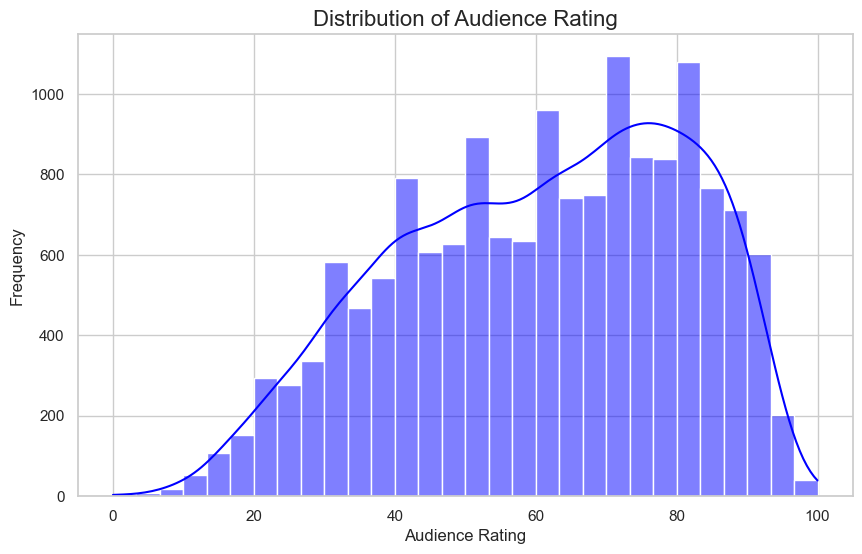

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data['audience_rating'], kde=True, bins=30, color='blue')
plt.title('Distribution of Audience Rating', fontsize=16)
plt.xlabel('Audience Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

The Target is normally skewed

## 3. Data Preprocessing

###  3.1 Feautre Engineering

In [12]:
data['in_theaters_date'] = pd.to_datetime(data['in_theaters_date'])
data['on_streaming_date'] = pd.to_datetime(data['on_streaming_date'])

# Calculate the difference between the two dates in days
data['date_difference'] = (data['on_streaming_date'] - data['in_theaters_date']).dt.days

The difference between when a movie is released in theaters and when it becomes available on streaming platforms might be an important feature. This could help in understanding patterns related to the audience ratings

In [13]:
data['rating'] = data['rating'].str.replace(r'[)]$', '', regex=True)
data['critics_consensus'].fillna('Missing', inplace=True)

In [14]:
unique_ratings = data['rating'].unique()
rating_mapping = {rating: idx for idx, rating in enumerate(unique_ratings)}
data['rating'] = data['rating'].map(rating_mapping)

rating_mapping

{'PG': 0, 'R': 1, 'NR': 2, 'G': 3, 'PG-13': 4, 'NC17': 5}

In the dataset, the rating feature contains categorical values representing the movie's age rating. To use this feature in machine learning models, we need to convert these categorical values into numerical representations. This process is known as **manual encoding** or **mapping**.

In [15]:
mapping = {'Rotten': 0, 'Certified Fresh': 1, 'Fresh': 2}

# Apply the mapping to the column
data['tomatometer_status'] = data['tomatometer_status'].map(mapping)
print(data['tomatometer_status'].unique())

[0 1 2]


In [16]:
unique_values = data['first_genre'].unique()
mapping = {genre: idx for idx, genre in enumerate(unique_values)}
data['genre'] = data['first_genre'].map(mapping)

In [17]:
data['critics_consensus'].fillna('Missing', inplace=True)


from textblob import TextBlob

# Function to classify reviews
def classify_review(review):
    polarity = TextBlob(review).sentiment.polarity
    return 1 if polarity > 0 else 0

# Apply the function to the reviews column
data['review_sentiment'] = data['critics_consensus'].apply(classify_review)

# Check the result
print(data[['critics_consensus', 'review_sentiment']].head())

                                   critics_consensus  review_sentiment
0  Though it may seem like just another Harry Pot...                 1
1  Nicole Holofcener's newest might seem slight i...                 1
2                                            Missing                 0
3  Sidney Lumet's feature debut is a superbly wri...                 1
4  One of Disney's finest live-action adventures,...                 1


Using the TextBlob package, critics' sentiments are analyzed and categorized as either positive or negative. They are then encoded into binary values, where positive sentiments are represented by **1** and negative sentiments by **0**.

In [18]:
d1 = data.copy()

In [19]:
d1.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,movie_year,first_genre,date_difference,review_sentiment
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,0,0,Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,0,49,144,53.0,2010,Action & Adventure,137,1
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,1,1,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,1,86,140,64.0,2010,Comedy,172,1
2,10,Blake Edwards' 10 stars Dudley Moore as George...,Missing,1,1,Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,2,68,22,53.0,1979,Comedy,6536,0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,2,2,Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,1,100,51,97.0,1957,Classics,16033,1
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",3,0,Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,2,89,27,74.0,1954,Action & Adventure,18036,1


In [20]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15667 entries, 0 to 16637
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         15667 non-null  object        
 1   movie_info          15662 non-null  object        
 2   critics_consensus   15667 non-null  object        
 3   rating              15667 non-null  int64         
 4   genre               15667 non-null  int64         
 5   directors           15585 non-null  object        
 6   writers             14510 non-null  object        
 7   cast                15443 non-null  object        
 8   in_theaters_date    15667 non-null  datetime64[ns]
 9   on_streaming_date   15667 non-null  datetime64[ns]
 10  runtime_in_minutes  15545 non-null  float64       
 11  studio_name         15396 non-null  object        
 12  tomatometer_status  15667 non-null  int64         
 13  tomatometer_rating  15667 non-null  int64         


In [21]:

columns_to_remove = [
    'first_genre', 'movie_title', 'movie_info', 
    'critics_consensus', 'directors', 'writers', 'cast', 
    'in_theaters_date', 'on_streaming_date','studio_name'
]

# Remove the columns
d1 = d1.drop(columns=columns_to_remove)

Since these features have minimal impact on the model's performance, we will remove them.

In [22]:
d1.head()

,rating,genre,runtime_in_minutes,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,movie_year,date_difference,review_sentiment
0,0,0,83.0,0,49,144,53.0,2010,137,1
1,1,1,90.0,1,86,140,64.0,2010,172,1
2,1,1,118.0,2,68,22,53.0,1979,6536,0
3,2,2,95.0,1,100,51,97.0,1957,16033,1
4,3,0,127.0,2,89,27,74.0,1954,18036,1


In [23]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15667 entries, 0 to 16637
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating              15667 non-null  int64  
 1   genre               15667 non-null  int64  
 2   runtime_in_minutes  15545 non-null  float64
 3   tomatometer_status  15667 non-null  int64  
 4   tomatometer_rating  15667 non-null  int64  
 5   tomatometer_count   15667 non-null  int64  
 6   audience_rating     15667 non-null  float64
 7   movie_year          15667 non-null  int64  
 8   date_difference     15667 non-null  int64  
 9   review_sentiment    15667 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


### 3.2 Handling the missing value

In [24]:
d1.isnull().sum()

rating                  0
genre                   0
runtime_in_minutes    122
tomatometer_status      0
tomatometer_rating      0
tomatometer_count       0
audience_rating         0
movie_year              0
date_difference         0
review_sentiment        0
dtype: int64

The **runtime_in_minutes** feature has 122 missing values, which we will replace with the mean of the column

In [25]:
d1['runtime_in_minutes'].fillna(d1['runtime_in_minutes'].mean(), inplace=True)

d1['runtime_in_minutes'].isnull().sum()

0

### 3.3 Standard Scaling

In [26]:
d1.describe()

,rating,genre,runtime_in_minutes,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,movie_year,date_difference,review_sentiment
count,15667.000000,15667.000000,15667.000000,15667.000000,15667.000000,15667.000000,15667.000000,15667.000000,15667.000000,15667.000000
mean,1.771941,2.706070,102.936250,0.933555,60.140742,59.256526,60.675879,1999.222123,3144.892832,0.359609
std,1.274176,2.319158,25.108207,0.899375,28.556158,67.438380,20.402046,19.419277,5927.742354,0.479901
min,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000,1914.000000,-8704.000000,0.000000
25%,1.000000,1.000000,91.000000,0.000000,38.000000,13.000000,45.000000,1993.000000,104.000000,0.000000
50%,1.000000,3.000000,100.000000,1.000000,65.000000,30.000000,63.000000,2006.000000,184.000000,0.000000
75%,2.000000,4.000000,111.000000,2.000000,85.000000,82.000000,78.000000,2013.000000,3220.500000,1.000000
max,5.000000,16.000000,2000.000000,2.000000,100.000000,497.000000,100.000000,2019.000000,33506.000000,1.000000


Since we can see the ranges of each feature using the describe() function, we can scale the continuous features to normalize them and ensure they are on a similar scale for better model performance

In [27]:
from sklearn.preprocessing import StandardScaler

# Select columns for scaling
continuous_columns = [
    'runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count', 
    'movie_year', 'date_difference'
]

# Apply StandardScaler to continuous features
scaler = StandardScaler()
d1[continuous_columns] = scaler.fit_transform(d1[continuous_columns])



## 4. Relatioship Analysis

In [28]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15667 entries, 0 to 16637
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating              15667 non-null  int64  
 1   genre               15667 non-null  int64  
 2   runtime_in_minutes  15667 non-null  float64
 3   tomatometer_status  15667 non-null  int64  
 4   tomatometer_rating  15667 non-null  float64
 5   tomatometer_count   15667 non-null  float64
 6   audience_rating     15667 non-null  float64
 7   movie_year          15667 non-null  float64
 8   date_difference     15667 non-null  float64
 9   review_sentiment    15667 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 1.3 MB


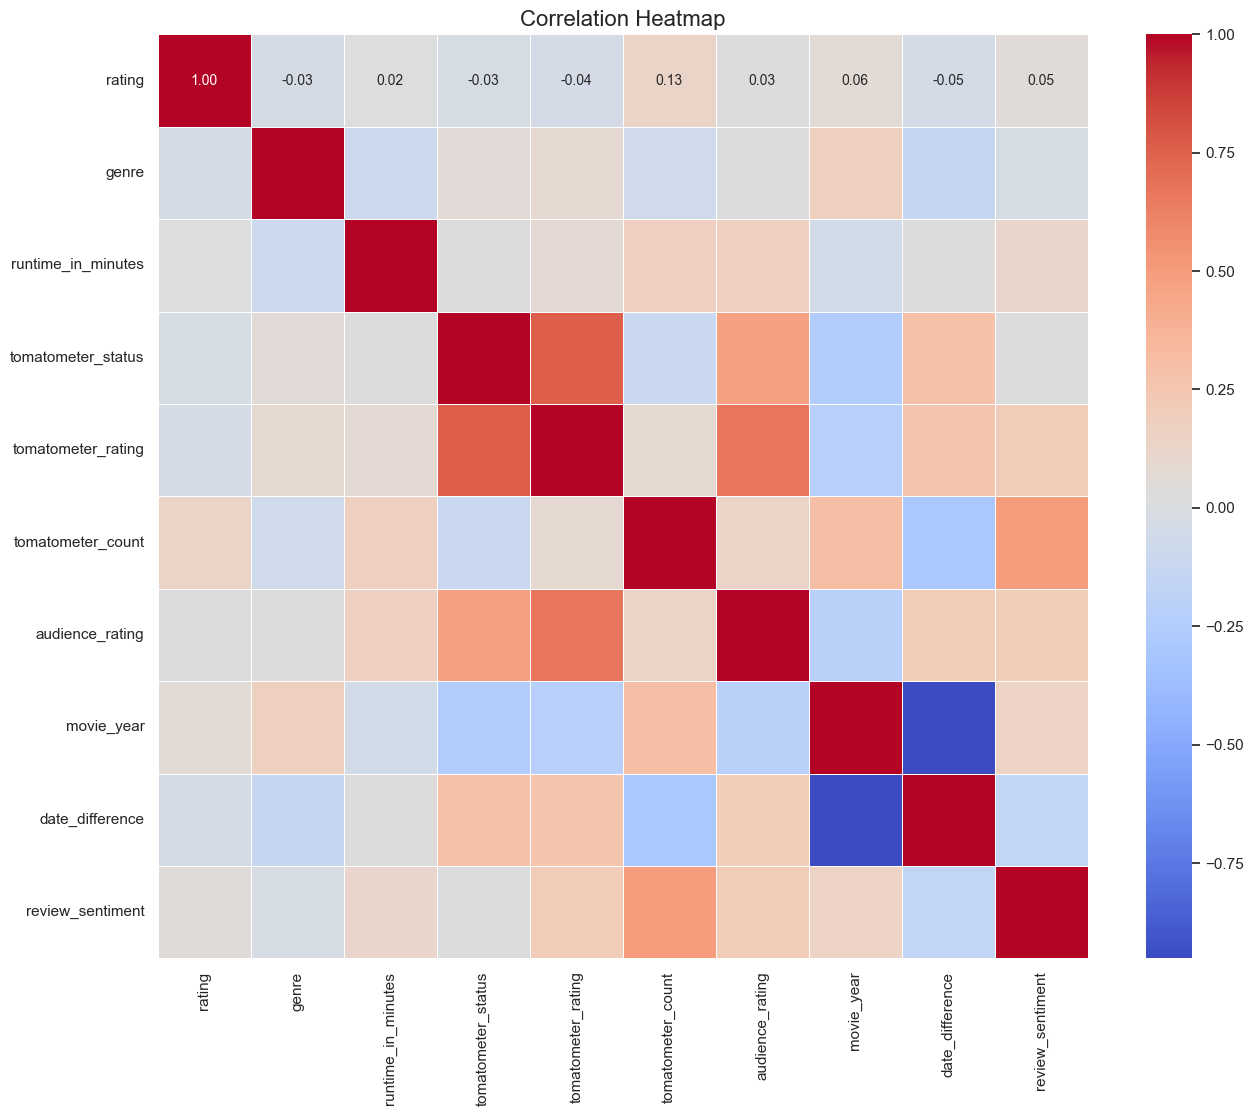

In [29]:

plt.figure(figsize=(15, 12))

# Create the heatmap with larger font size for annotations
sns.heatmap(d1.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={'size': 10})

# Display the plot with a larger title
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


From the heatmap, we can conclude that there's a strong positive correlations between **rating** and **tomatometer_rating**, **audience_rating**, and **runtime_in_minutes**. This suggests that higher critic and audience ratings are associated with longer runtimes

## 5. Model Training and Evaluation

### 5.1  Train and Test Split                                                   

In [30]:
X = d1.drop('audience_rating', axis=1)  # Dropping the target
y = d1['audience_rating']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5.2 Initializing the Models

In [32]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(objective='regression', random_state=42),
    'CatBoost': cb.CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)
}


### 5.3 Trainig the models and evaluating the best model

In [33]:
results = {}
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

# Find the best model based on R2 score (or RMSE, depending on your preference)
best_model = results_df['R2'].idxmax()
print(f"Best performing model: {best_model}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 12533, number of used features: 9
[LightGBM] [Info] Start training from score 60.781696
                          MSE       RMSE        R2
Random Forest      192.865891  13.887616  0.554319
Decision Tree      376.242502  19.396971  0.130566
Gradient Boosting  182.101344  13.494493  0.579194
SVR                196.557258  14.019888  0.545789
XGBoost            189.990907  13.783719  0.560962
LightGBM           177.907106  13.338182  0.588886
CatBoost           179.014870  13.379644  0.586326
Best performing model: LightGBM


Based on these metrics, **LightGBM** is the best performing model with the highest R2 score and lowest **MSE** and **RMSE** demonstrating its effectiveness in this regression task


### 5.4 Hyperparameter Tuning on LightGBM using Random Search CV

In [34]:
from sklearn.model_selection import RandomizedSearchCV


In [35]:
param_dist = {
    'num_leaves': [31, 50, 100, 200],  # Number of leaves in a tree
    'max_depth': [-1, 5, 10, 20],      # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],   # Number of boosting rounds
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples to train each tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of features to train each tree
    'min_child_samples': [20, 50, 100],  # Minimum number of data needed in a child (leaf)
    'reg_alpha': [0, 0.1, 0.5, 1.0],   # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization
}


In [36]:
lgbm = lgb.LGBMRegressor(objective='regression', random_state=42)


random_search = RandomizedSearchCV(
    estimator=lgbm, 
    param_distributions=param_dist, 
    n_iter=100,  # Number of parameter settings to sample
    scoring='neg_mean_squared_error',  # Scoring metric for regression
    cv=5,  # 5-fold cross-validation
    verbose=1,  # To show progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [37]:
random_search.fit(X_train, y_train)

# Get the best parameters from the RandomizedSearchCV
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_lgbm = random_search.best_estimator_

# Predict on the test set
y_pred = best_lgbm.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Optimized MSE: {mse}")
print(f"Optimized RMSE: {rmse}")
print(f"Optimized R2: {r2}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 12533, number of used features: 9
[LightGBM] [Info] Start training from score 60.781696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Optimized MSE

***Best Parameters for LightGBM Regressor***

- **subsample**: 0.9
- **reg_lambda**: 1.0
- **reg_alpha**: 0.1
- **num_leaves**: 31
- **n_estimators**: 100
- **min_child_samples**: 50
- **max_depth**: 10
- **learning_rate**: 0.1
- **colsample_bytree**: 0.8


In [38]:
lgb_best_model = lgb.LGBMRegressor(
    subsample=0.9,
    reg_lambda=1.0,
    reg_alpha=0.1,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=50,
    max_depth=10,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1  # Suppress warnings and output
)

# Fit the LightGBM model
lgb_best_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_best_model.predict(X_test)

# Calculate metrics for LightGBM
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# Print the results
print(f"LightGBM MSE: {mse_lgb}")
print(f"LightGBM RMSE: {rmse_lgb}")
print(f"LightGBM R2: {r2_lgb}")


LightGBM MSE: 176.79336604773007
LightGBM RMSE: 13.296366648364135
LightGBM R2: 0.5914597412813227


After hyperparameter tuning, the **LightGBM** model is performing exceptionally well, providing optimized results with a lower **MSE**, **RMSE**, and higher **R2** score compared to other models. Hence, **LightGBM** gives higher accuracy than any other regression model tested.

### 5.5 LightGBM's Feature Importance Plot

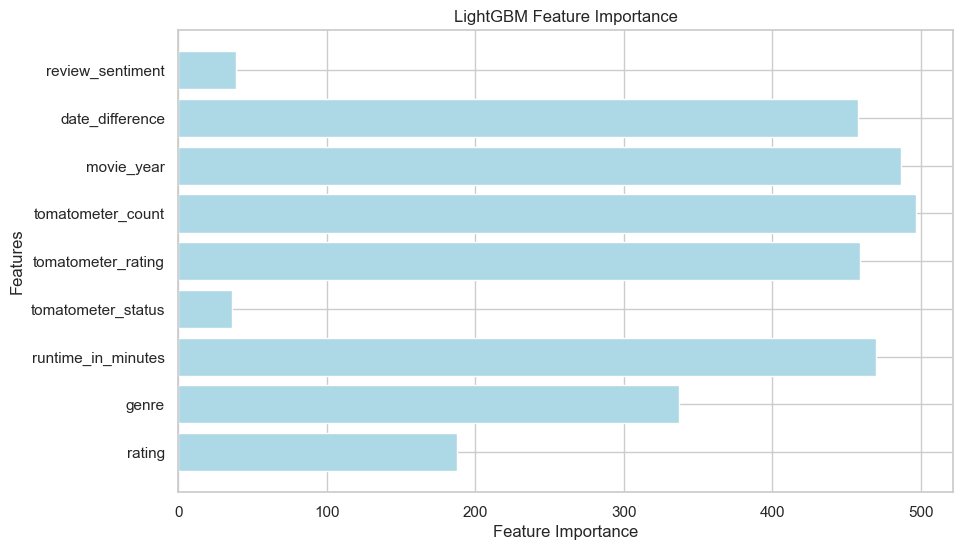

In [39]:
import matplotlib.pyplot as plt

# Get the feature importance from the fitted LightGBM model
lgb_feature_importance = lgb_best_model.feature_importances_

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, lgb_feature_importance, color='lightblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.show()


### 5.6 Actual Values v/s Predicted Values based on Light GBM

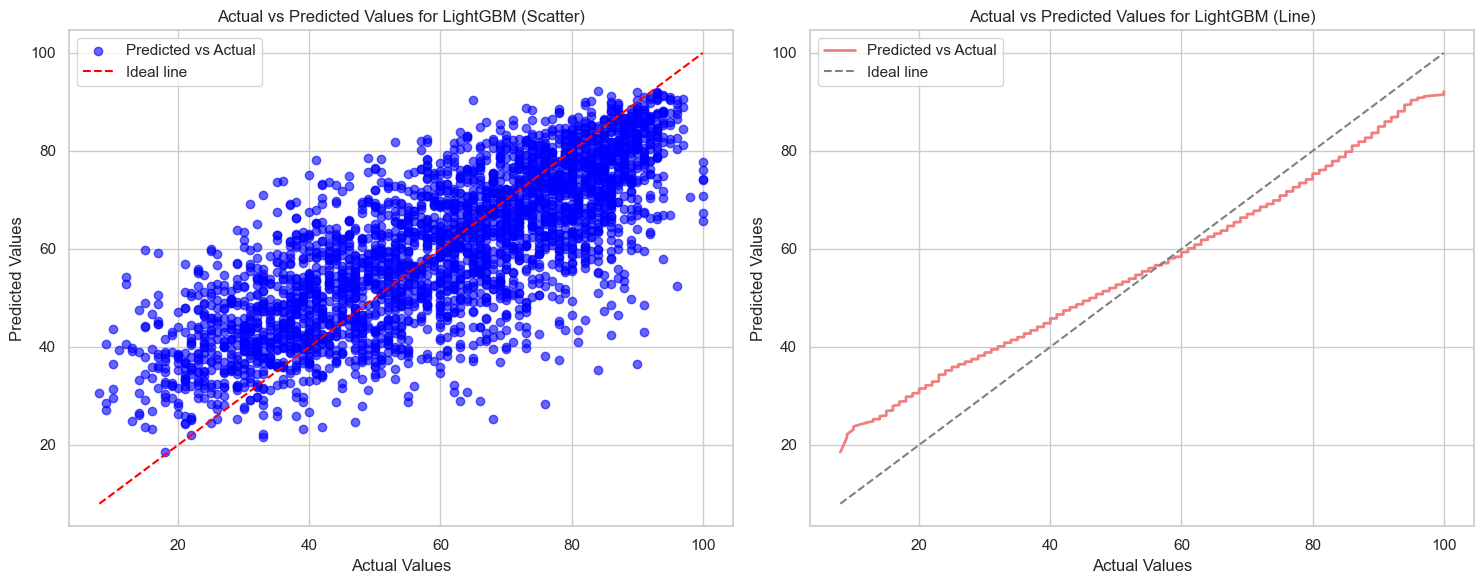

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the actual and predicted values for line plotting
sorted_actual = np.sort(y_test)
sorted_predicted = np.sort(y_pred)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot (Actual vs Predicted)
ax[0].scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal line')
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Actual vs Predicted Values for LightGBM (Scatter)')
ax[0].legend()

# Plot 2: Line plot (Sorted Actual vs Sorted Predicted)
ax[1].plot(sorted_actual, sorted_predicted, color='lightcoral', linestyle='-', linewidth=2, label='Predicted vs Actual')
ax[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='grey', linestyle='--', label='Ideal line')
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Predicted Values')
ax[1].set_title('Actual vs Predicted Values for LightGBM (Line)')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


The LightGBM model demonstrates strong predictive performance, with predicted values closely aligning with actual values in both the scatter plot and the line plot. This indicates a high degree of accuracy in capturing the underlying relationships within the data.

### 5.7 Predeicting the model with sample data

In [41]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from textblob import TextBlob


continuous_columns = [
    'runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count', 
    'movie_year', 'date_difference'
]

best_model = lgb_best_model


def analyze_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return 1 if sentiment > 0 else 0

movie = input("Movie Name: ")


user_input = input("Please enter your critics: ")


# Predict sentiment
review_sentiment = analyze_sentiment(user_input)

# Prepare sample data
sample_data = pd.DataFrame({
    'rating': [3],  
    'genre': [5],  
    'runtime_in_minutes': [120],  
    'tomatometer_status': [2],  
    'tomatometer_rating': [80],  
    'tomatometer_count': [95],  
    'movie_year' : [2020],
    'date_difference' : [120],
    'review_sentiment': [review_sentiment]
})


sample_data[continuous_columns] = scaler.transform(sample_data[continuous_columns])

y_pred = best_model.predict(sample_data)

# Output the prediction
print(f"Predicted Audience Rating for the movie {movie}: {y_pred[0]}")

Movie Name: 20,000 Leagues Under The Sea
Please enter your critics: One of Disney's finest live-action adventures
Predicted Audience Rating for the movie 20,000 Leagues Under The Sea: 78.32493912830662


The prediction for the movie **20,000 Leagues Under the Sea** estimates an audience rating of approximately **78.3%**, based on the features used to train the model. This indicates that the model is performing effectivel

## 6. Save the model and the scaler for deploying the model in Streamlit

In [42]:
import joblib

# Save the trained model
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

In [43]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']